In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from astropy.io import ascii
from astropy.table import Table
from tqdm import tqdm
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
import numpy.ma as ma
from sqlalchemy import text
import pandas as pd
import matplotlib.pylab as pl
import matplotlib as mpl
import matplotlib.ticker as mticker
from scipy import stats
import pickle


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
loc = '/Users/allybaldelli/Desktop/AMNH-stuff/Doublet-Quantifiers'
sys.path.append(os.path.abspath(loc))

# Importing scripts needed
from Doublet_Quantifiers.curvefit import *
from Doublet_Quantifiers.models import *

mypath = '/Users/allybaldelli/Desktop/AMNH-stuff/quantifying_clouds_ally'
sys.path.append(os.path.abspath(mypath))

from functions.data_tools import *
from functions.visualizing_sonora_tools import *

In [3]:

# opening convolved data dictionary 
with open(mypath + "/diamondback-data/pickle_files/t1500_convolve_data_dict.pkl", "rb") as f:
    convolve_data_dict = pickle.load(f)

# opening pseudo-voigt parameter DataFrame
with open(mypath + "/diamondback-data/pickle_files/t1500_parameter_df.pkl", "rb") as f:
    parameter_df = pickle.load(f)

## Plotting

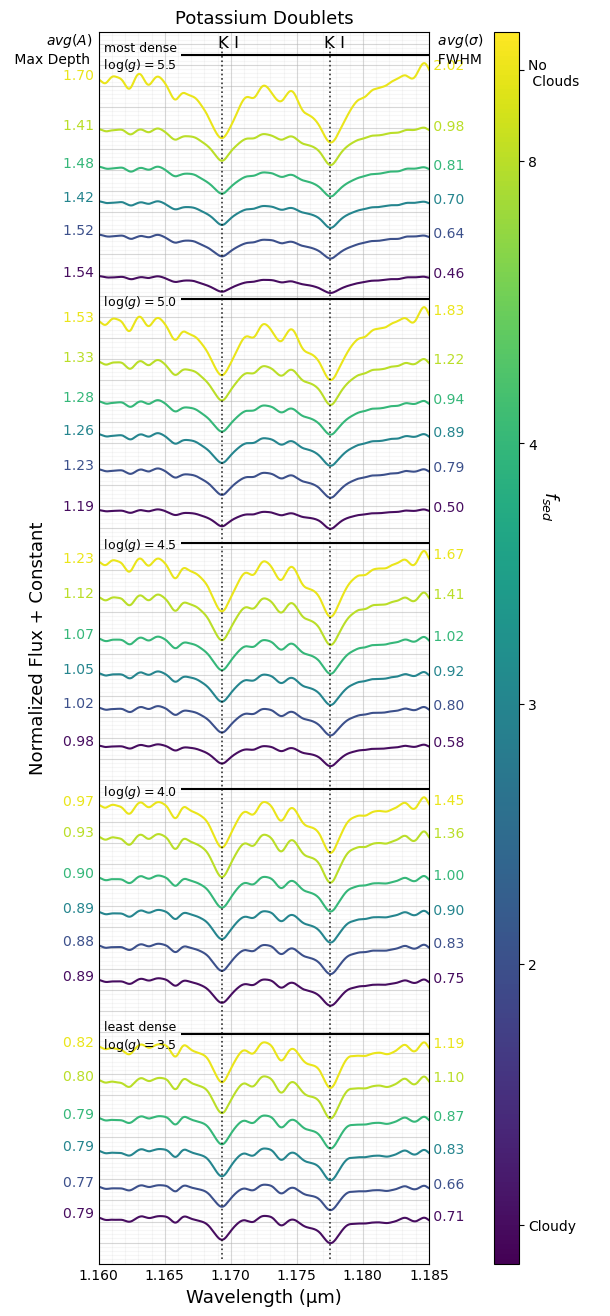

In [4]:
long_plot(parameter_df, convolve_data_dict, x_min = 1.16, x_max = 1.185, 
                  x_increment = 0.005, const_spacing = 1.5, norm_scaling = 7e10,
                  title = "Potassium Doublets", color_by_logg = False)

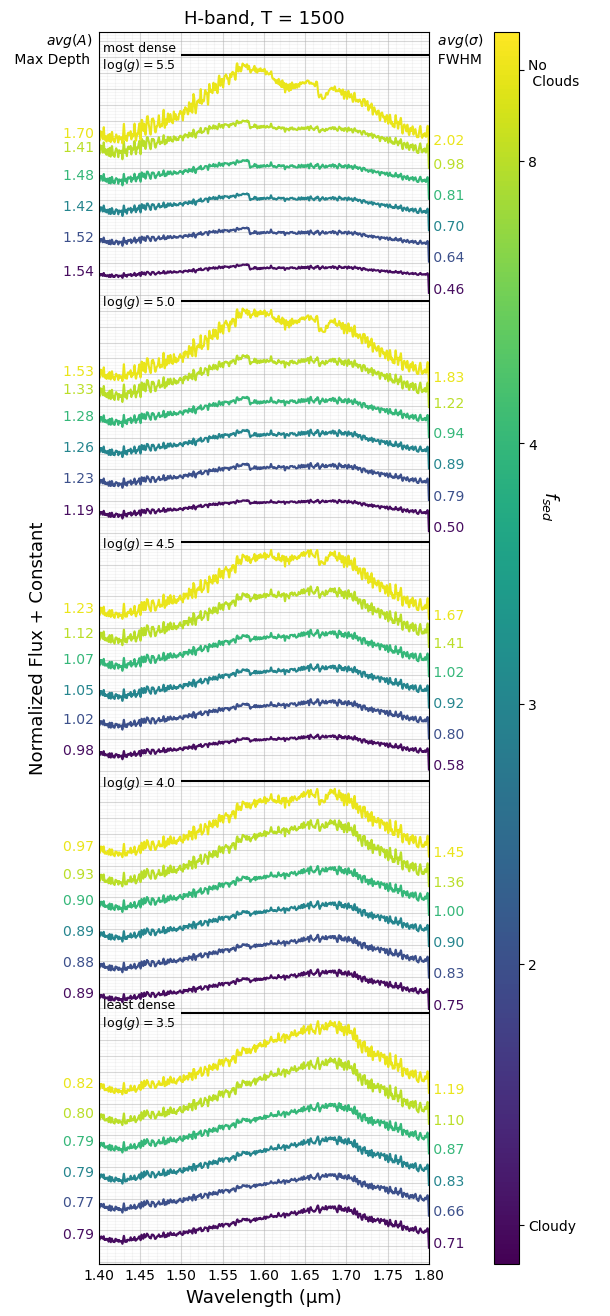

In [5]:
long_plot(parameter_df, convolve_data_dict, x_min = 1.4, x_max = 1.8, 
                  x_increment = 0.05, const_spacing = 2, norm_scaling = 5e10,
                  title = "H-band, Т = 1500", color_by_logg = False)

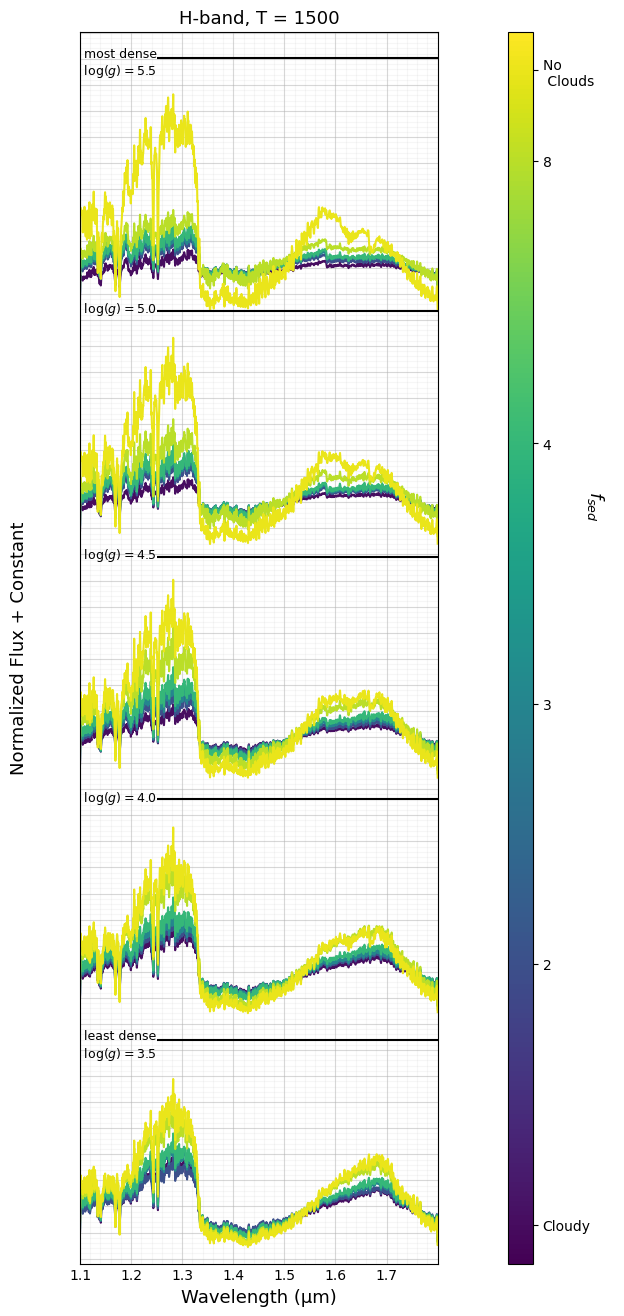

In [6]:
#overlaid version

# variables here can easily be changed
x_min, x_max = 1.1, 1.8  # x limits used
x_increment = 0.1  # x-ticks
const_spacing = 6  # spacing between spectra
norm_scaling = 6.5e10  # constant spectra is dived by
title = "H-band, Т = 1500"
color_by_logg = False  # if false color is by fsed

if color_by_logg:
    index = parameter_df.sort_values(
        by=['clouds', 'logg']).index.to_numpy()  # order of spectra plotted
else:
    index = parameter_df.sort_values(by=['logg', 'clouds']).index.to_numpy()

label_loc_l = []  # where left label located on y axis
label_loc_r = []  # where right label located on y axis

if color_by_logg:
    const = [ 1.5*const_spacing*(i//5)
             for i in range(30)]  # constants to be added to flux
else:
    const = [1.5*const_spacing*(i//6) for i in range(30)]

fig, ax = plt.subplots(figsize=(6.5, 16))

# plotting each spectra
for n, i in enumerate(index):
    # setting constants, labels, color needed
    if color_by_logg:
        color = logg_colors(norm_g(parameter_df.logg[i]))
    else:
        color = fsed_colors(norm_f(parameter_df.clouds[i]))
    name = parameter_df.name[i]
    c = const[n]

    # normalizing
    norm = (convolve_data_dict[name][1, :]) / norm_scaling

    # plotting
    ax.plot(convolve_data_dict[name][0, :], norm + c, alpha=1, color=color)

    # These are arbitary since no labels choosen to get limits set better
    l_index = np.where(np.isclose(convolve_data_dict[name][0, :], 1.4))[0][0]  # x index in spectra of left side
    r_index = np.where(np.isclose(convolve_data_dict[name][0, :], 1.3))[0][0]  # x index in spectra of right side
    label_loc_r.append(norm[r_index] + c)   # y axis location for labels
    label_loc_l.append(norm[l_index] + c)

    # A_label = f' {-parameter_df.A1[i] / 1e11:.2f}'  # string of A
    # ax.annotate(A_label,
    #             xy=(x_max, label_loc_r[n]), xycoords='data', color=color)
    # FWHM_label = f'{parameter_df.FWHM1[i]*1e3:.2f} '  # string for FWHM
    # ax.annotate(FWHM_label, horizontalalignment='right',
    #             xy=(x_min, label_loc_l[n]), xycoords='data', color=color)


# setting limits
y_max = max(label_loc_r)+ 4  # right side generally larger of 2
y_min = min(label_loc_l)-1
# limits in x and y
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# setting ticks
ax.set_yticks([n for n in range(int(y_min), int(y_max) + 1)])  # y-ticks
# creating blank label in y
ax.set_yticklabels(['' for n in range(int(y_min), int(y_max) + 1)])
# setting x-ticks with x-increment set at top
ax.set_xticks(ticks=[round(x_min + n*x_increment, 3)
              for n in range(0, int((x_max-x_min)/x_increment)+1)])
# creating grid
ax.tick_params(which='major', length=5, width=0,
               direction='in', top=True, right=True)
ax.tick_params(which='minor', length=2, width=0,
               direction='in', top=True, right=True)
# grid lines
ax.minorticks_on()
ax.grid(visible=True, which='major', alpha=.5)
ax.grid(visible=True, which='minor', alpha=.1)


# adding axis titles/labels
ax.set_xlabel('Wavelength (μm)', fontsize=13)
ax.set_ylabel("Normalized Flux + Constant\n\n", fontsize=13)
ax.set_title(title, fontsize=13)

# # setting parameter labels
# ax.annotate(r"$avg(A)$  " "\n Max Depth  \n", xy=(x_min, y_max),
#             ha='right',
#             va='top',
#             xycoords='data', color='k')

# ax.annotate(r"  $avg(\sigma)$" "\n  FWHM \n", xy=(1.190, y_max),
#             ha='left',
#             va='top',
#             xycoords='data', color='k')

# # potassium vertical lines
# ax.vlines([1.16935, 1.1775], ymin=y_min, ymax=y_max-1,
#           linestyle='dotted', color='k', linewidth=1.2, alpha=.8)
# ax.annotate("K I ", xy=(1.16901, y_max-1),
#             xycoords='data', color='k', fontsize=12)
# ax.annotate("K I ", xy=(1.177062, y_max-1),
#             xycoords='data', color='k', fontsize=12)


# horizontal lines

if color_by_logg:  
    # 1.5*const_spacing
    hline_y = [label_loc_r[(i*5)-1] + const_spacing/2 for i in range(1, 7)]
    pretty_fsed = [' Cloudy \n $f_{sed} = 1$',  r' $f_{sed} = 2$', r' $f_{sed} = 3$',
                   r' $f_{sed} = 4$', r' $f_{sed} = 8$', 'No Clouds']
    ax.hlines(hline_y, xmin=x_min + 0.1, xmax=x_max,  color='k')

    for i, y in enumerate(hline_y):
        ax.annotate(pretty_fsed[i], xy=(x_min + 0.0001, y + .5),
                    xycoords='data', color='k', fontsize=9,
                    ha='left', va='top')
else:
    hline_y = [label_loc_r[(i*6)-1] + const_spacing/2 for i in range(1, 6)]
    pretty_logg = [' least dense\n'+r' $\log(g) = 3.5$',
                   r' $\log(g) = 4.0$', r' $\log(g) = 4.5$',
                   r' $\log(g) = 5.0$',
                   ' most dense \n' + r' $\log(g) = 5.5$']
    ax.hlines(hline_y, xmin=x_min + 0.15, xmax=x_max,  color='k')

    for i, y in enumerate(hline_y):
        ax.annotate(pretty_logg[i], xy=(x_min + 0.00001, y + .4),
                    xycoords='data', color='k', fontsize=9,
                    ha='left', va='top')


# color bar
if color_by_logg:
    axcb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_g, cmap=logg_colors),
                        ticks=logg_num, shrink=1, format=mticker.FixedFormatter(logg_ticks),
                        aspect=50,  pad=.14, ax= ax)
    axcb.set_label(' ', fontsize=12)  # empty label
    ax.annotate(r'$\log(g)$', xy=(.9, .5), xycoords='figure fraction',
                rotation=270, fontsize=13)  # actual color bar label

else:
    axcb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_f, cmap=fsed_colors),
                        ticks=fsed_num, shrink=1, format=mticker.FixedFormatter(fsed_ticks),
                        aspect=50, pad=.14, ax = ax)
    axcb.set_label(' ', fontsize=12)  # empty label
    ax.annotate(r'$f_{sed}$', xy=(.9, .5), xycoords='figure fraction',
                rotation=270, fontsize=13)  # actual color bar label

# plt.savefig('overlay_fsed_H-band.png')